# Histopathologic Cancer Detection: Results and Analysis

In this notebook, we'll present and analyze the results of our models for the Histopathologic Cancer Detection task. We'll evaluate their performance, visualize predictions, analyze error patterns, and compare different approaches.

## Setup and Data Loading

First, let's import the necessary libraries and load the dataset.

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm.notebook import tqdm
import cv2
from PIL import Image
import itertools

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [6]:
# Set paths to the dataset and models
BASE_DIR = '../data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
TRAIN_LABELS_PATH = os.path.join(BASE_DIR, 'train_labels.csv')
MODELS_DIR = '../data/models'

# Create models directory if it doesn't exist
os.makedirs(MODELS_DIR, exist_ok=True)

# Load the training labels
try:
    train_labels = pd.read_csv(TRAIN_LABELS_PATH)
    print(f"Successfully loaded training labels with shape: {train_labels.shape}")
except Exception as e:
    print(f"Error loading training labels: {e}")
    print("Please ensure the dataset is downloaded and the paths are correctly set.")

Successfully loaded training labels with shape: (220025, 2)


## Load Trained Models

Let's load the models we trained in the previous notebook. If the models haven't been trained yet, you'll need to run the training code in the Model Architecture notebook first.

In [7]:
def load_trained_model(model_path):
    """Load a trained model from the specified path"""
    try:
        model = load_model(model_path)
        print(f"Successfully loaded model from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        print("Please ensure the model has been trained and saved correctly.")
        return None

In [8]:
# Load the trained models
model_paths = {
    'custom_cnn': os.path.join(MODELS_DIR, 'custom_cnn.keras'),
    'resnet50': os.path.join(MODELS_DIR, 'resnet50.keras'),
    'efficientnet': os.path.join(MODELS_DIR, 'efficientnet.keras'),
    'mobilenet': os.path.join(MODELS_DIR, 'mobilenet.keras')
}

models = {}
for name, path in model_paths.items():
    models[name] = load_trained_model(path)

Successfully loaded model from ../data/models/custom_cnn.keras
Successfully loaded model from ../data/models/resnet50.keras
Successfully loaded model from ../data/models/efficientnet.keras
Successfully loaded model from ../data/models/mobilenet.keras


## Prepare Validation Data

Let's prepare the validation data to evaluate our models.

In [49]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_labels, 
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=train_labels['label']  # Ensure class balance in both sets
)

train_df = train_df.copy()
val_df = val_df.copy()
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

val_df['id'] = val_df['id'] + '.tif'

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 176020
Validation set size: 44005


In [50]:
# Create a validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 44005 validated image filenames belonging to 2 classes.


## Model Evaluation

Now, let's evaluate our models on the validation set and compare their performance.

In [11]:
def evaluate_model(model, generator):
    """Evaluate a model on the given data generator"""
    if model is None:
        return None, None, None
    
    # Reset the generator to the beginning
    generator.reset()
    
    # Get the true labels
    y_true = generator.classes
    
    # Get predictions
    y_pred_proba = model.predict(generator, verbose=1)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Calculate metrics
    auc = roc_auc_score(y_true, y_pred_proba)
    
    return y_true, y_pred_proba, y_pred, auc

In [12]:
# Evaluate each model
results = {}
for name, model in models.items():
    if model is not None:
        print(f"\nEvaluating {name} model...")
        y_true, y_pred_proba, y_pred, auc = evaluate_model(model, val_generator)
        results[name] = {
            'y_true': y_true,
            'y_pred_proba': y_pred_proba,
            'y_pred': y_pred,
            'auc': auc
        }
        print(f"{name} AUC: {auc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))


Evaluating custom_cnn model...


/Users/luke/src/github.com/lukelittle/csca5642-histopathologic-cancer-detection/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 161s 117ms/step
custom_cnn AUC: 0.9621

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     26182
           1       0.75      0.95      0.84     17823

    accuracy                           0.85     44005
   macro avg       0.85      0.87      0.85     44005
weighted avg       0.87      0.85      0.85     44005


Evaluating resnet50 model...
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 422s 305ms/step
resnet50 AUC: 0.7595

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.97      0.76     26182
           1       0.79      0.14      0.23     17823

    accuracy                           0.64     44005
   macro avg       0.71      0.56      0.50     44005
weighted avg       0.69      0.64      0.55     44005


Evaluating efficientnet model...
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 443s 321ms/step
efficientnet AUC: 0.5592

Classification Report:


/Users/luke/src/github.com/lukelittle/csca5642-histopathologic-cancer-detection/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/luke/src/github.com/lukelittle/csca5642-histopathologic-cancer-detection/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/luke/src/github.com/lukelittle/csca5642-histopathologic-cancer-detection/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set 

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 307s 222ms/step
mobilenet AUC: 0.9185

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     26182
           1       0.82      0.79      0.80     17823

    accuracy                           0.84     44005
   macro avg       0.84      0.83      0.84     44005
weighted avg       0.84      0.84      0.84     44005



### Confusion Matrices

Let's visualize the confusion matrices for each model to better understand their performance.

In [51]:
def plot_confusion_matrix(y_true, y_pred, classes, title, normalize=False, cmap=plt.cm.Blues):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)
    
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()
    plt.show()


Confusion Matrix for custom_cnn model:


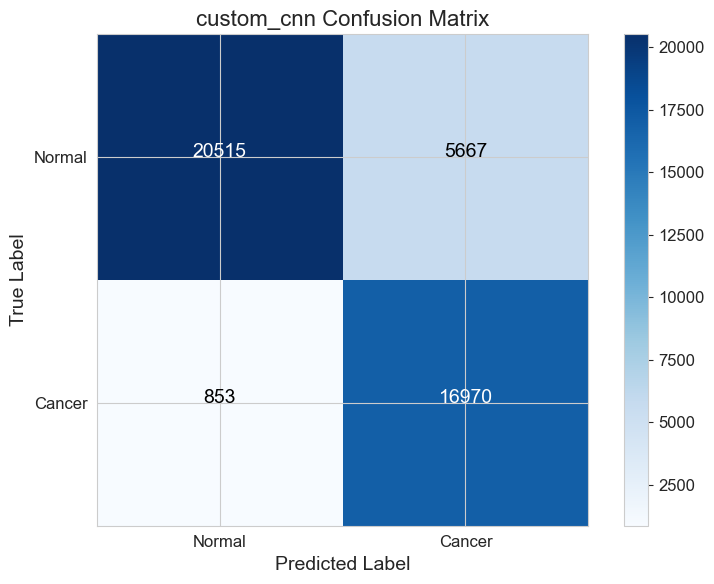


Normalized Confusion Matrix for custom_cnn model:


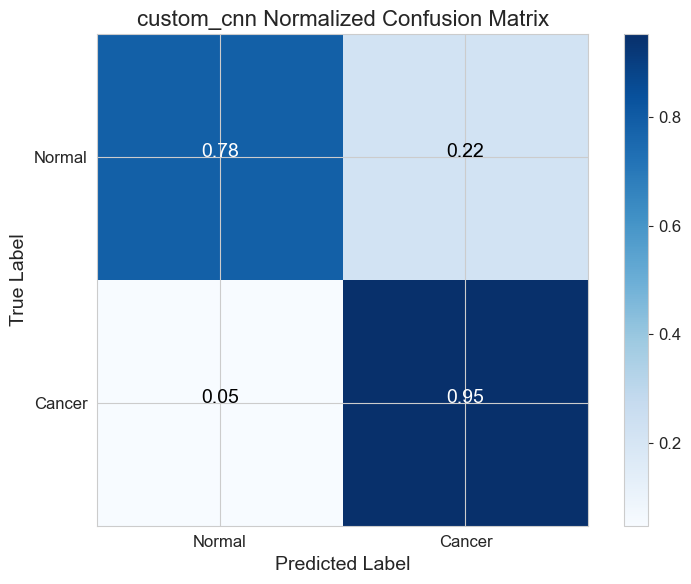


Confusion Matrix for resnet50 model:


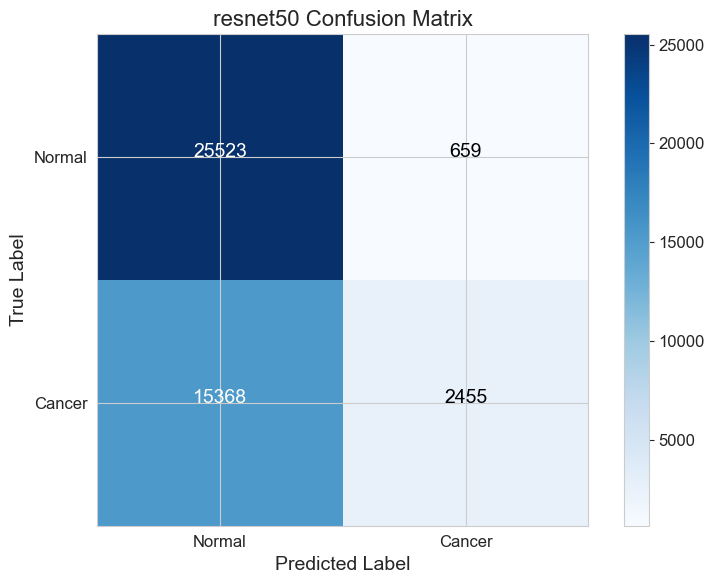


Normalized Confusion Matrix for resnet50 model:


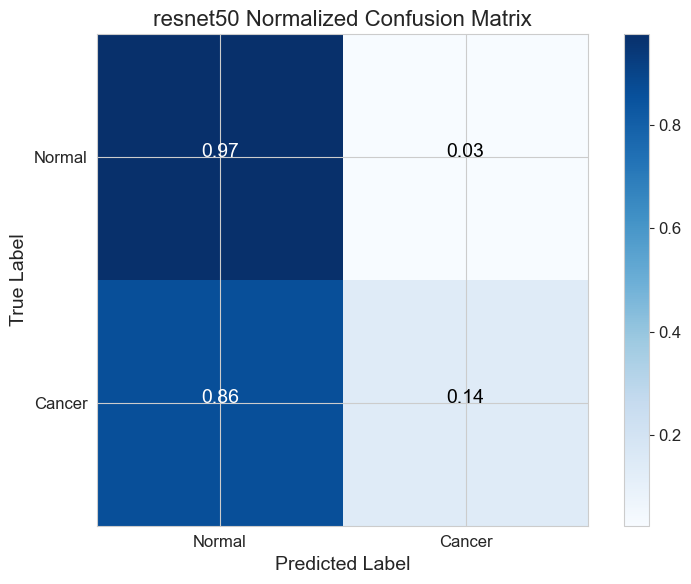


Confusion Matrix for efficientnet model:


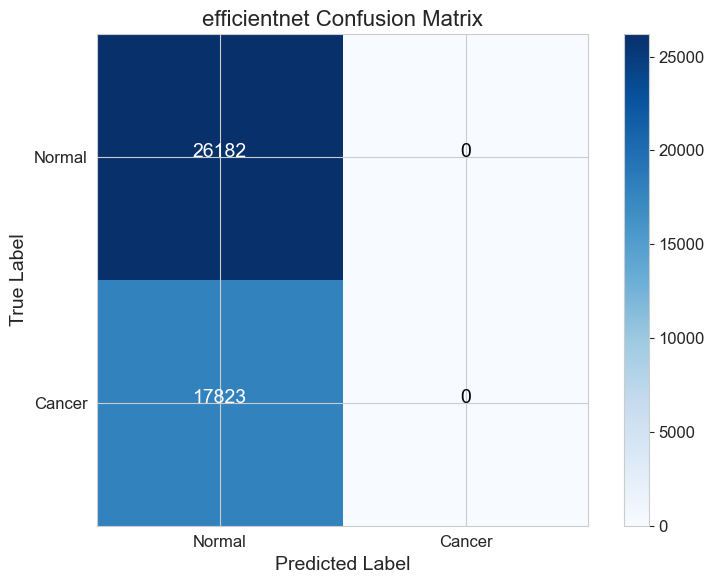


Normalized Confusion Matrix for efficientnet model:


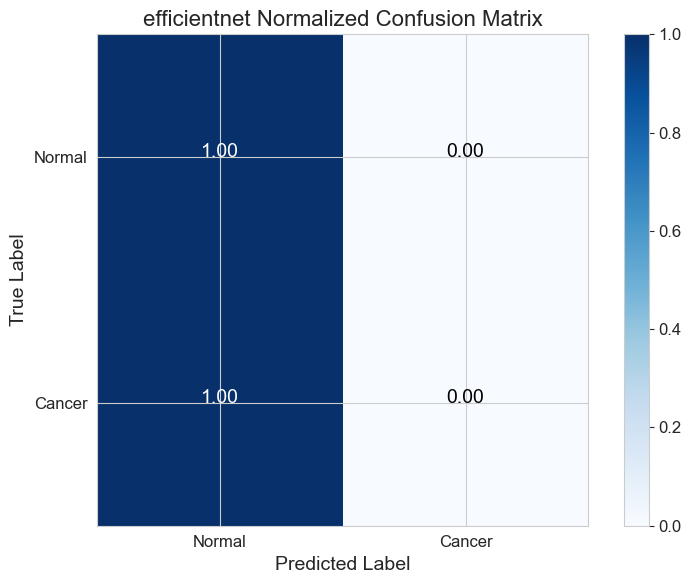


Confusion Matrix for mobilenet model:


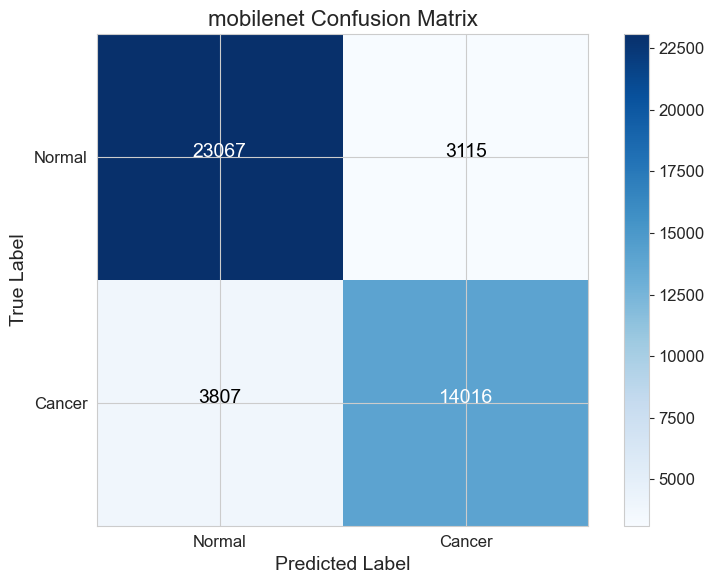


Normalized Confusion Matrix for mobilenet model:


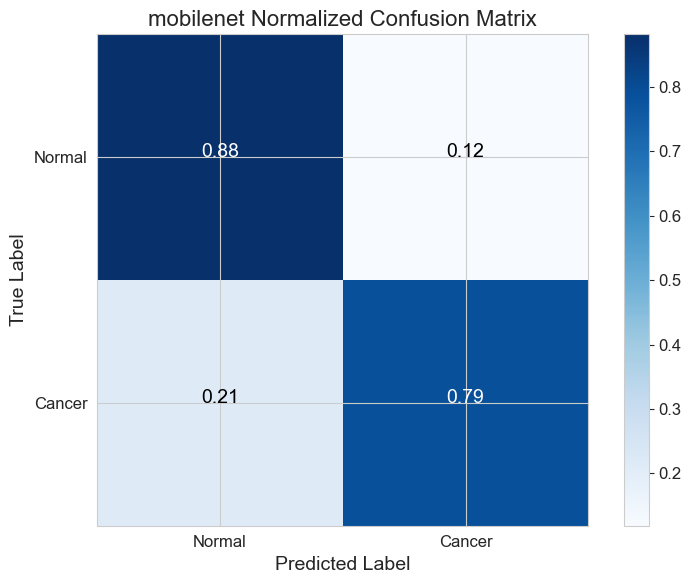

In [52]:
# Plot confusion matrices for each model
classes = ['Normal', 'Cancer']
for name, result in results.items():
    print(f"\nConfusion Matrix for {name} model:")
    plot_confusion_matrix(result['y_true'], result['y_pred'], classes, f"{name} Confusion Matrix")
    
    print(f"\nNormalized Confusion Matrix for {name} model:")
    plot_confusion_matrix(result['y_true'], result['y_pred'], classes, f"{name} Normalized Confusion Matrix", normalize=True)

### ROC Curves

Let's plot the ROC curves for each model to visualize their performance across different classification thresholds.

In [53]:
def plot_roc_curves(results):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(10, 8))
    
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(result['y_true'], result['y_pred_proba'])
        auc = result['auc']
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

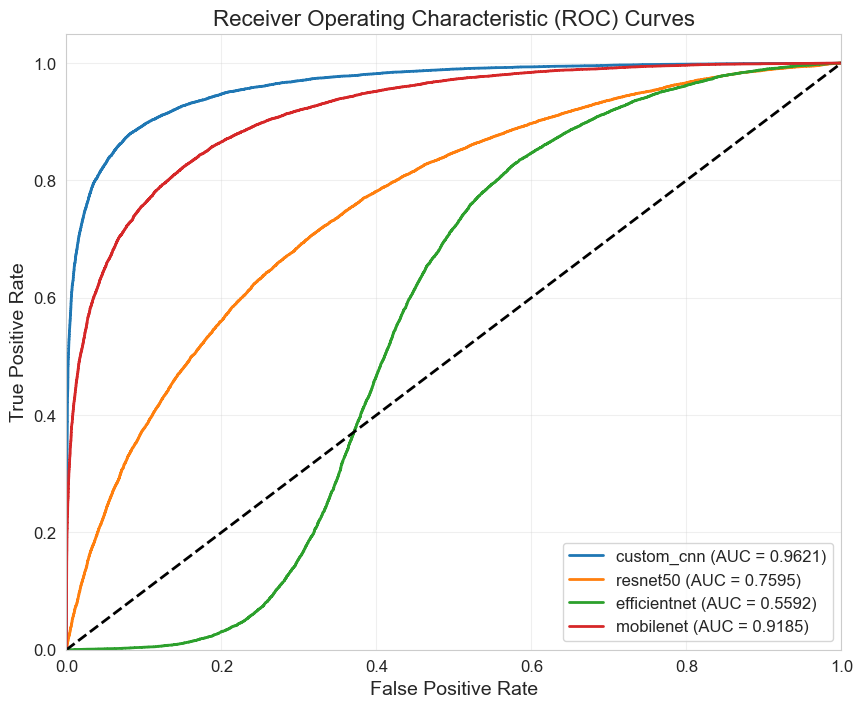

In [16]:
# Plot ROC curves
plot_roc_curves(results)

### Precision-Recall Curves

Let's also plot precision-recall curves, which are particularly useful for imbalanced datasets.

In [17]:
def plot_precision_recall_curves(results):
    """Plot precision-recall curves for multiple models"""
    plt.figure(figsize=(10, 8))
    
    for name, result in results.items():
        precision, recall, _ = precision_recall_curve(result['y_true'], result['y_pred_proba'])
        ap = average_precision_score(result['y_true'], result['y_pred_proba'])
        plt.plot(recall, precision, lw=2, label=f'{name} (AP = {ap:.4f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Precision-Recall Curves', fontsize=16)
    plt.legend(loc="lower left", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

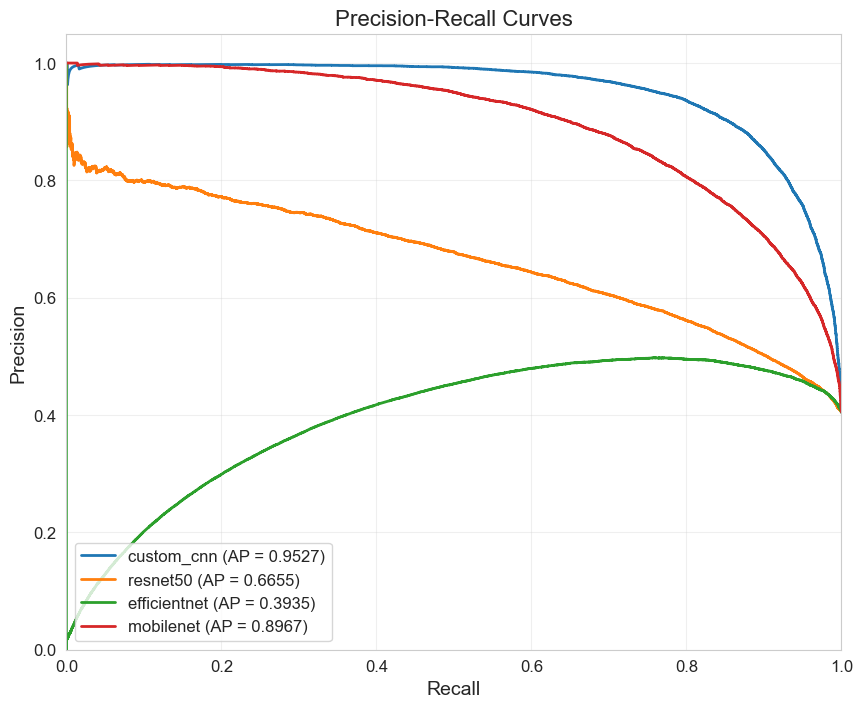

In [18]:
# Plot precision-recall curves
plot_precision_recall_curves(results)

## Model Comparison

Let's compare the performance of our models across different metrics.

In [19]:
def calculate_metrics(y_true, y_pred, y_pred_proba):
    """Calculate various performance metrics"""
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_pred_proba),
        'ap': average_precision_score(y_true, y_pred_proba)
    }
    
    return metrics

In [20]:
# Calculate metrics for each model
metrics_dict = {}
for name, result in results.items():
    metrics_dict[name] = calculate_metrics(result['y_true'], result['y_pred'], result['y_pred_proba'])

# Create a DataFrame for easy comparison
metrics_df = pd.DataFrame(metrics_dict).T
metrics_df = metrics_df.round(4)

# Display the metrics
print("Model Performance Metrics:")
display(metrics_df)

# Highlight the best model for each metric
best_model = metrics_df.idxmax()
print("\nBest model for each metric:")
for metric, model in best_model.items():
    print(f"{metric}: {model} ({metrics_df.loc[model, metric]:.4f})")

/Users/luke/src/github.com/lukelittle/csca5642-histopathologic-cancer-detection/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Performance Metrics:


,accuracy,precision,recall,f1,auc,ap
custom_cnn,0.8518,0.7497,0.9521,0.8389,0.9621,0.9527
resnet50,0.6358,0.7884,0.1377,0.2345,0.7595,0.6655
efficientnet,0.5950,0.0000,0.0000,0.0000,0.5592,0.3935
mobilenet,0.8427,0.8182,0.7864,0.8020,0.9185,0.8967



Best model for each metric:
accuracy: custom_cnn (0.8518)
precision: mobilenet (0.8182)
recall: custom_cnn (0.9521)
f1: custom_cnn (0.8389)
auc: custom_cnn (0.9621)
ap: custom_cnn (0.9527)


<Figure size 1400x800 with 0 Axes>

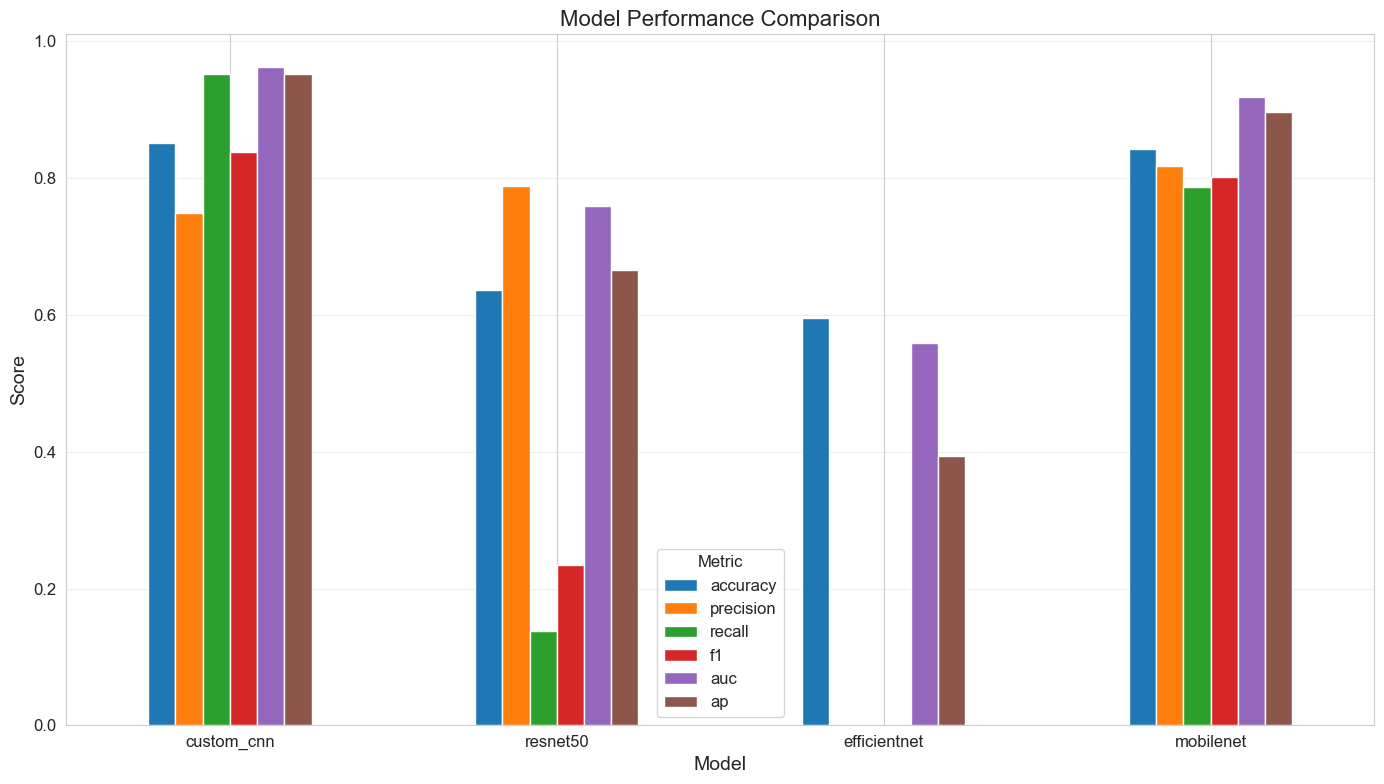

In [21]:
# Visualize the metrics comparison
plt.figure(figsize=(14, 8))
metrics_df.plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.legend(title='Metric', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Error Analysis

Let's analyze the errors made by our best-performing model to gain insights into its limitations and potential areas for improvement.

In [54]:
# Identify the best model based on AUC
best_model_name = metrics_df['auc'].idxmax()
print(f"Best model based on AUC: {best_model_name} (AUC = {metrics_df.loc[best_model_name, 'auc']:.4f})")

# Get the results for the best model
best_result = results[best_model_name]

Best model based on AUC: custom_cnn (AUC = 0.9621)


In [55]:
def load_and_preprocess_image(image_id, directory, target_size=(96, 96), normalize=True):
    """Load and preprocess an image from the specified directory"""
    try:
        img_path = os.path.join(directory, image_id)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Resize if needed
        if img.shape[:2] != target_size:
            img = cv2.resize(img, target_size)
        
        # Normalize pixel values to [0, 1]
        if normalize:
            img = img.astype(np.float32) / 255.0
        
        return img
    except Exception as e:
        print(f"Error loading image {image_id}: {e}")
        return None

In [56]:
# Find misclassified examples
val_df_reset = val_df.reset_index(drop=True)
val_df_reset['predicted'] = best_result['y_pred']
val_df_reset['probability'] = best_result['y_pred_proba'].flatten()
val_df_reset['correct'] = val_df_reset['label'].astype(int) == val_df_reset['predicted']

# False positives (predicted cancer, actually normal)
false_positives = val_df_reset[(val_df_reset['label'] == '0') & (val_df_reset['predicted'] == 1)]
print(f"Number of false positives: {len(false_positives)}")

# False negatives (predicted normal, actually cancer)
false_negatives = val_df_reset[(val_df_reset['label'] == '1') & (val_df_reset['predicted'] == 0)]
print(f"Number of false negatives: {len(false_negatives)}")

Number of false positives: 5667
Number of false negatives: 853


In [57]:
def display_misclassified_examples(df, category, num_examples=5):
    """Display misclassified examples with their predicted probabilities"""
    if len(df) == 0:
        print(f"No {category} examples found.")
        return
    
    # Sort by prediction confidence (probability closest to 0.5 is least confident)
    if category == 'false_positives':
        df_sorted = df.sort_values(by='probability', ascending=False).head(num_examples)
    else:  # false_negatives
        df_sorted = df.sort_values(by='probability', ascending=True).head(num_examples)
    
    # Set up the figure
    fig, axes = plt.subplots(1, min(num_examples, len(df_sorted)), figsize=(min(num_examples, len(df_sorted))*4, 4))
    if min(num_examples, len(df_sorted)) == 1:
        axes = [axes]
    
    # Display each example
    for i, (_, row) in enumerate(df_sorted.iterrows()):
        if i >= num_examples:
            break
            
        img = load_and_preprocess_image(row['id'], TRAIN_DIR, normalize=False)
        if img is not None:
            axes[i].imshow(img)
            true_label = 'Cancer' if row['label'] == '1' else 'Normal'
            pred_label = 'Cancer' if row['predicted'] == 1 else 'Normal'
            axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nProb: {row['probability']:.4f}")
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"{category.replace('_', ' ').title()}", fontsize=16, y=1.05)
    plt.show()

False Positives (Normal tissue classified as Cancer):


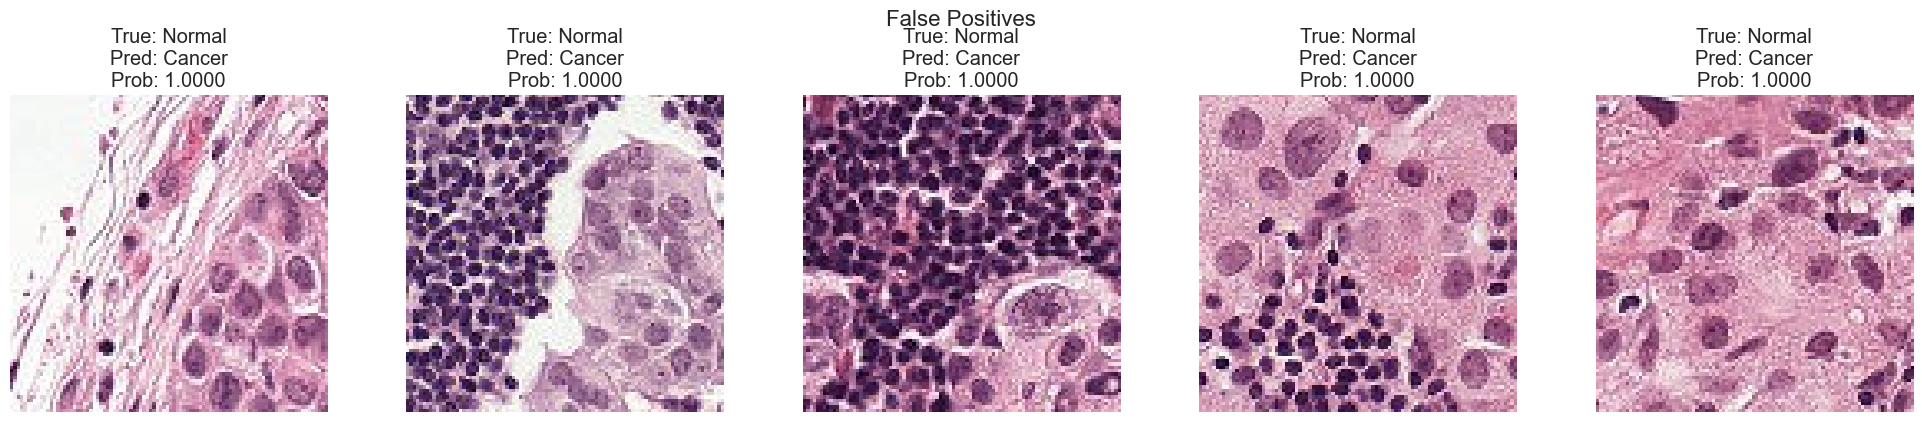


False Negatives (Cancer tissue classified as Normal):


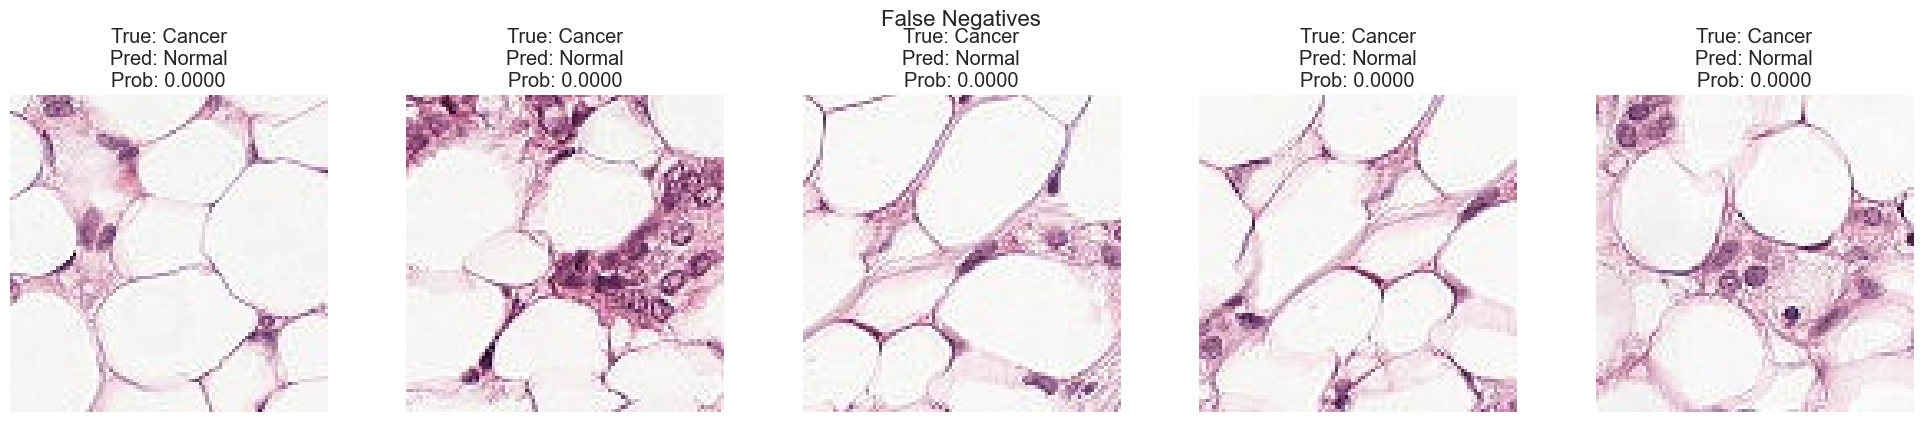

In [58]:
# Display false positives
print("False Positives (Normal tissue classified as Cancer):")
display_misclassified_examples(false_positives, 'false_positives')

# Display false negatives
print("\nFalse Negatives (Cancer tissue classified as Normal):")
display_misclassified_examples(false_negatives, 'false_negatives')

### Analysis of Prediction Confidence

Let's analyze the prediction confidence (probability) distribution for correct and incorrect predictions.

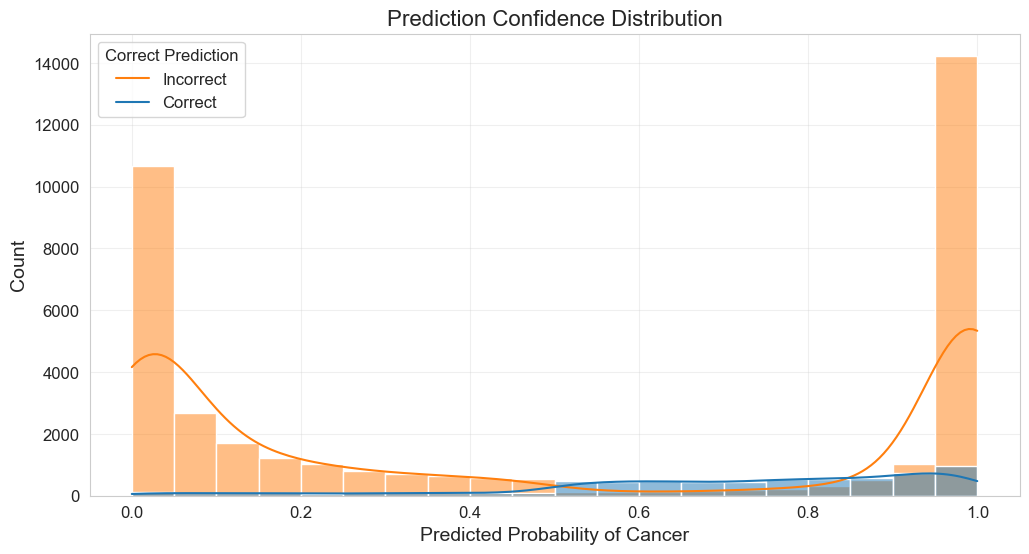

In [59]:
# Analyze prediction confidence
plt.figure(figsize=(12, 6))
sns.histplot(data=val_df_reset, x='probability', hue='correct', bins=20, kde=True)
plt.title('Prediction Confidence Distribution', fontsize=16)
plt.xlabel('Predicted Probability of Cancer', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Correct Prediction', labels=['Incorrect', 'Correct'])
plt.grid(True, alpha=0.3)
plt.show()

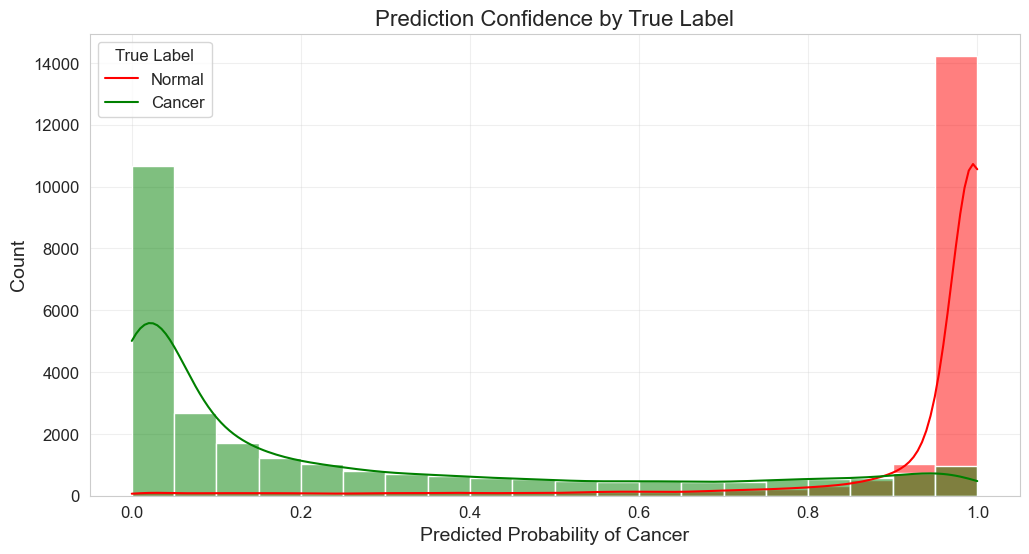

In [60]:
# Analyze prediction confidence by true label
plt.figure(figsize=(12, 6))
sns.histplot(data=val_df_reset, x='probability', hue='label', bins=20, kde=True, palette=['green', 'red'])
plt.title('Prediction Confidence by True Label', fontsize=16)
plt.xlabel('Predicted Probability of Cancer', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='True Label', labels=['Normal', 'Cancer'])
plt.grid(True, alpha=0.3)
plt.show()

## Visualizing Model Predictions

Let's visualize some examples of correct predictions to better understand what patterns the model is learning.

In [61]:
# Find correctly classified examples
correct_normal = val_df_reset[(val_df_reset['label'] == 0) & (val_df_reset['correct'])]
correct_cancer = val_df_reset[(val_df_reset['label'] == 1) & (val_df_reset['correct'])]

# Get high-confidence examples
high_conf_normal = correct_normal.sort_values(by='probability', ascending=True).head(5)
high_conf_cancer = correct_cancer.sort_values(by='probability', ascending=False).head(5)

In [44]:
# Display high-confidence correct examples
print("High-Confidence Normal Tissue Examples (Correctly Classified):")
display_misclassified_examples(high_conf_normal, 'high_conf_normal', num_examples=5)

print("\nHigh-Confidence Cancer Tissue Examples (Correctly Classified):")
display_misclassified_examples(high_conf_cancer, 'high_conf_cancer', num_examples=5)

High-Confidence Normal Tissue Examples (Correctly Classified):
No high_conf_normal examples found.

High-Confidence Cancer Tissue Examples (Correctly Classified):
No high_conf_cancer examples found.


## Threshold Optimization

The default classification threshold is 0.5, but we can optimize this threshold based on our specific requirements (e.g., prioritizing sensitivity over specificity or vice versa).

In [62]:
def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """Find the optimal threshold that maximizes the specified metric"""
    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
    
    # Define the metric function based on the specified metric
    if metric == 'f1':
        metric_func = lambda y_true, y_pred: f1_score(y_true, y_pred)
    elif metric == 'precision':
        metric_func = lambda y_true, y_pred: precision_score(y_true, y_pred)
    elif metric == 'recall':
        metric_func = lambda y_true, y_pred: recall_score(y_true, y_pred)
    elif metric == 'accuracy':
        metric_func = lambda y_true, y_pred: accuracy_score(y_true, y_pred)
    else:
        raise ValueError(f"Unsupported metric: {metric}")
    
    # Try different thresholds and calculate the metric
    thresholds = np.arange(0.1, 1.0, 0.05)
    scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int).flatten()
        score = metric_func(y_true, y_pred)
        scores.append(score)
    
    # Find the threshold that maximizes the metric
    best_score_idx = np.argmax(scores)
    best_threshold = thresholds[best_score_idx]
    best_score = scores[best_score_idx]
    
    return best_threshold, best_score, thresholds, scores

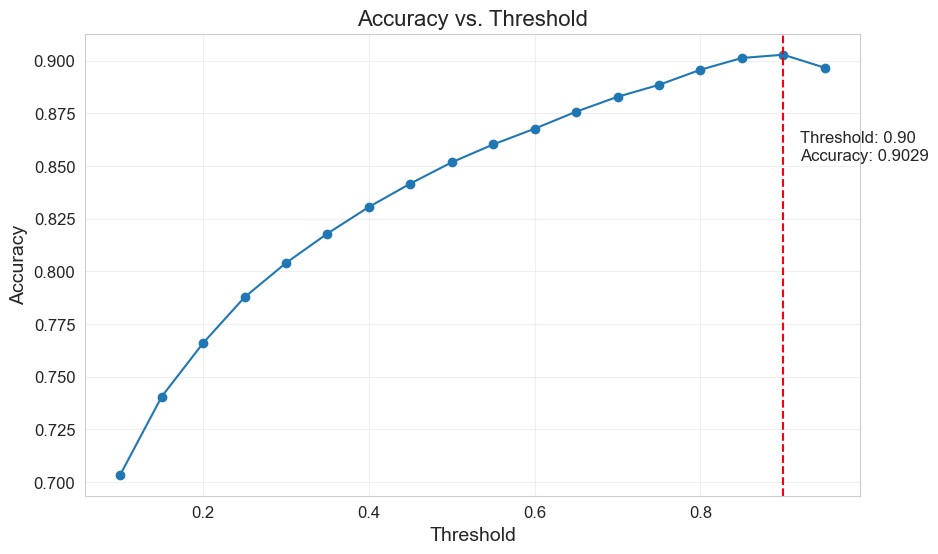

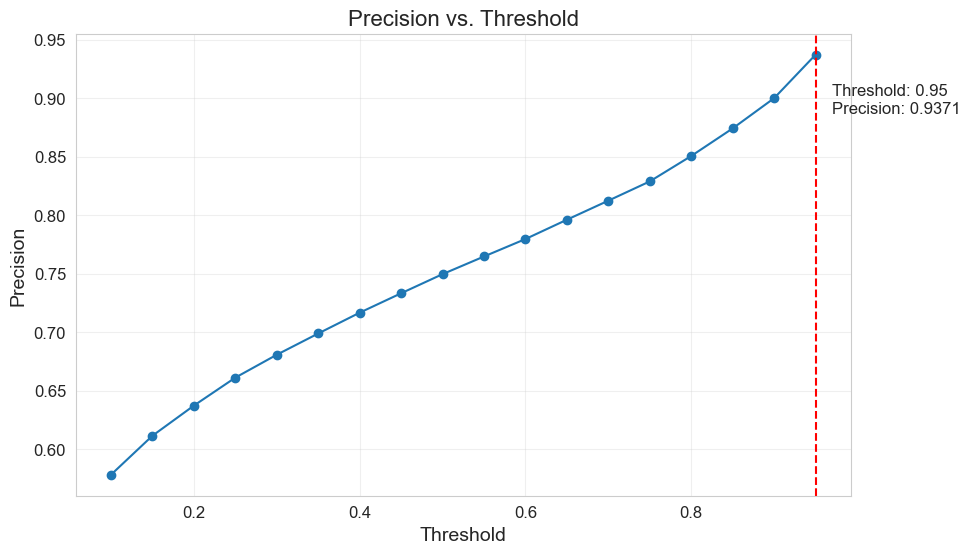

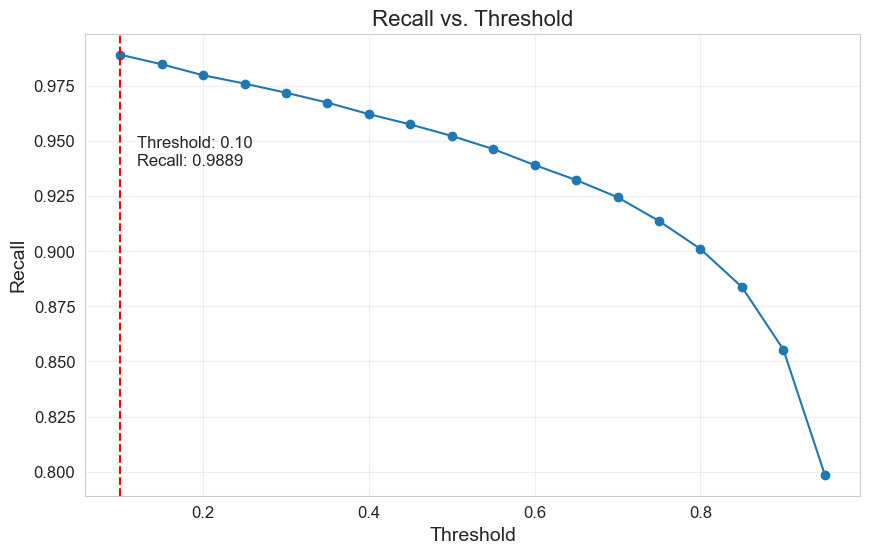

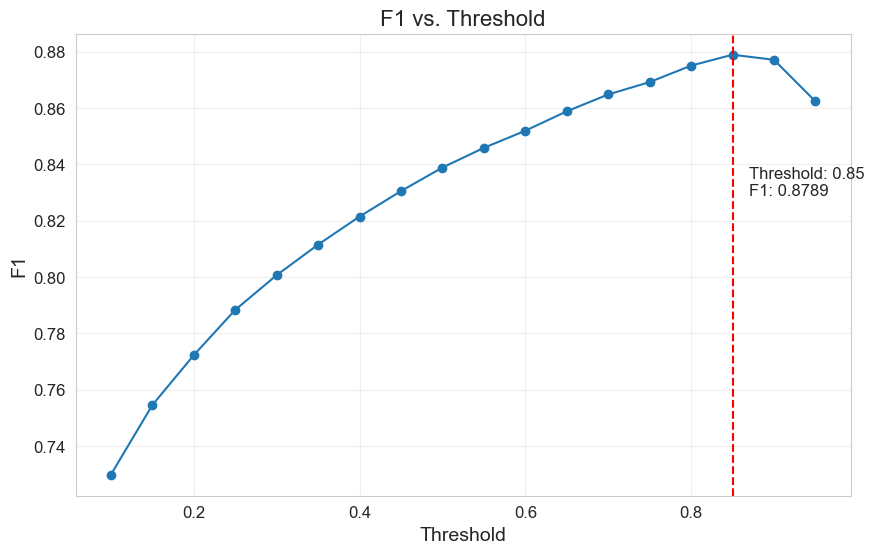

Optimal thresholds for different metrics:
Accuracy: 0.90
Precision: 0.95
Recall: 0.10
F1: 0.85


In [63]:
# Find optimal thresholds for different metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']
best_thresholds = {}

for metric in metrics:
    best_threshold, best_score, thresholds, scores = find_optimal_threshold(
        best_result['y_true'], best_result['y_pred_proba'], metric=metric
    )
    best_thresholds[metric] = best_threshold
    
    # Plot the metric vs. threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, scores, 'o-')
    plt.axvline(x=best_threshold, color='r', linestyle='--')
    plt.text(best_threshold + 0.02, best_score - 0.05, 
             f'Threshold: {best_threshold:.2f}\n{metric.capitalize()}: {best_score:.4f}',
             fontsize=12)
    plt.title(f'{metric.capitalize()} vs. Threshold', fontsize=16)
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

print("Optimal thresholds for different metrics:")
for metric, threshold in best_thresholds.items():
    print(f"{metric.capitalize()}: {threshold:.2f}")

## Preparing for Kaggle Submission

Let's prepare a submission file for the Kaggle competition using our best model.

In [64]:
# Load the test data
test_files = os.listdir(TEST_DIR)
test_ids = [file.split('.')[0] for file in test_files if file.endswith('.tif')]
print(f"Number of test files: {len(test_ids)}")

Number of test files: 57458


In [69]:
# Create a test data generator
test_df = pd.DataFrame({'id': test_ids})
test_df['id'] = test_df['id'] + '.tif'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,
    x_col='id',
    y_col=None,  # No labels for test data
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [70]:
# Get predictions on the test data using the best model
best_model = models[best_model_name]
test_predictions = best_model.predict(test_generator, verbose=1)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 235s 131ms/step


In [71]:
# Create a submission file
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': (test_predictions > 0.5).astype(int).flatten()
})

# Save the submission file
submission_path = '../submission.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Submission file saved to {submission_path}")
print(f"Number of samples: {len(submission_df)}")
print(f"Class distribution in submission:\n{submission_df['label'].value_counts()}")

Submission file saved to ../submission.csv
Number of samples: 57458
Class distribution in submission:
label
0    28816
1    28642
Name: count, dtype: int64
